# Outlier detection with several methods

Based on:
http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html

When the amount of contamination is known, this example illustrates three different ways of performing Novelty and Outlier Detection:

* based on a robust estimator of covariance, which is assuming that the data are Gaussian distributed and performs better than the One-Class SVM in that case.

* using the One-Class SVM and its ability to capture the shape of the data set, hence performing better when the data is strongly non-Gaussian, i.e. with two well-separated clusters;

* using the Isolation Forest algorithm, which is based on random forests and hence more adapted to large-dimensional settings, even if it performs quite well in the examples below.

* using the Local Outlier Factor to measure the local deviation of a given data point with respect to its neighbors by comparing their local density.


The ground truth about inliers and outliers is given by the points colors while the orange-filled area indicates which points are reported as inliers by each method.

Here, we assume that we know the fraction of outliers in the datasets. Thus rather than using the ‘predict’ method of the objects, we set the threshold on the decision_function to separate out the corresponding fraction.

In [61]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

In [62]:
rng = np.random.RandomState(42)

In [63]:
n_samples = 200
outliers_fraction = 0.25

In [69]:
# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
y = np.ones(n_samples, dtype=int)
y[-n_outliers:] = -1

In [81]:
# Data generation
np.random.seed(42)
clusters_separation = 0 # 1, 2, 3, ...

X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - clusters_separation
X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + clusters_separation
X = np.r_[X1, X2]

# Add outliers
X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

In [82]:
# Plot results
def plot_result(clf, clf_name):
    if clf_name == "LocalOutlierFactor":
        # decision_function is private for LOF
        Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    
    fig, axes = plt.subplots(figsize=(12, 8))
    axes.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)
    a = axes.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')
    axes.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
    b = axes.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white', s=20, edgecolor='k')
    c = axes.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black', s=20, edgecolor='k')
    axes.axis('tight')
    axes.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        loc='lower right')
    axes.set_xlabel("%s (errors: %d)" % (clf_name, n_errors))
    axes.set_xlim((-7, 7))
    axes.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle(clf_name)

## 1. Elliptic Envelope

In [106]:
from sklearn.covariance import EllipticEnvelope
elliptic_env = EllipticEnvelope(contamination=outliers_fraction)
elliptic_env.fit(X)

EllipticEnvelope(assume_centered=False, contamination=0.25, random_state=None,
         store_precision=True, support_fraction=None)

In [107]:
scores_pred = elliptic_env.decision_function(X)
y_pred = elliptic_env.predict(X)

In [108]:
threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)
n_errors = (y_pred != ground_truth).sum()

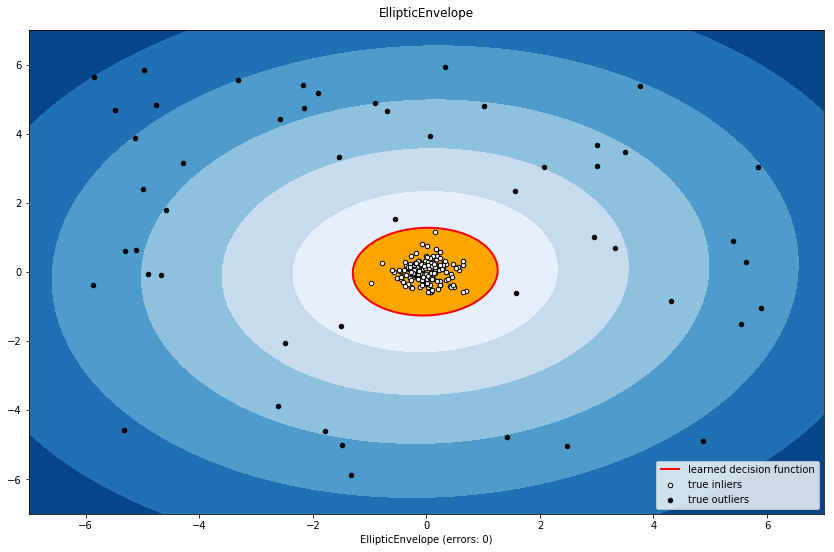

In [109]:
plot_result(elliptic_env, "EllipticEnvelope")

## 2. One-class SVM

In [83]:
from sklearn.svm import OneClassSVM
one_svm = OneClassSVM(nu=0.95*outliers_fraction+0.05, kernel="rbf", gamma=0.1)
one_svm.fit(X)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.2875, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [84]:
scores_pred = one_svm.decision_function(X)
y_pred = one_svm.predict(X)

In [85]:
threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)
n_errors = (y_pred != y).sum()

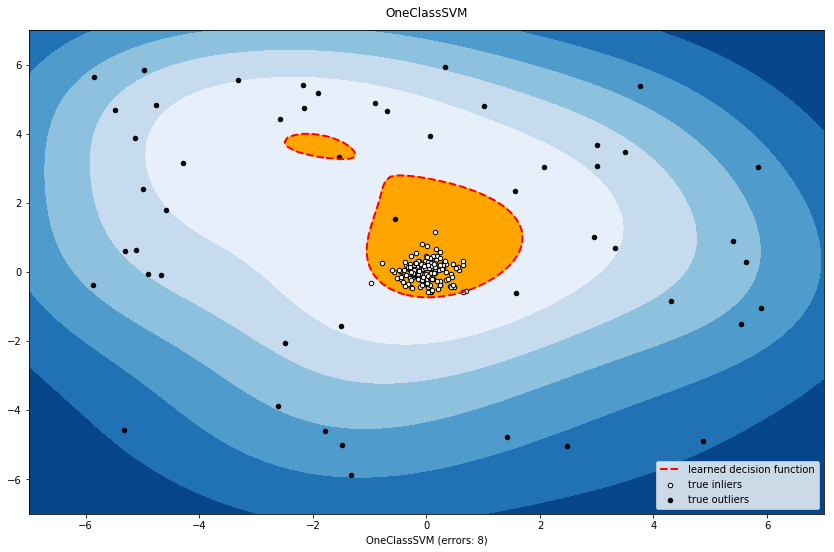

In [86]:
plot_result(one_svm, "OneClassSVM")

## 3. Isolation Forest

In [93]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(max_samples=n_samples, contamination=outliers_fraction, random_state=rng)
iso_forest.fit(X)

IsolationForest(bootstrap=False, contamination=0.25, max_features=1.0,
        max_samples=200, n_estimators=100, n_jobs=1,
        random_state=<mtrand.RandomState object at 0x1164545a0>, verbose=0)

In [94]:
scores_pred = iso_forest.decision_function(X)
y_pred = elliptic_env.predict(X)

In [95]:
threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)
n_errors = (y_pred != y).sum()

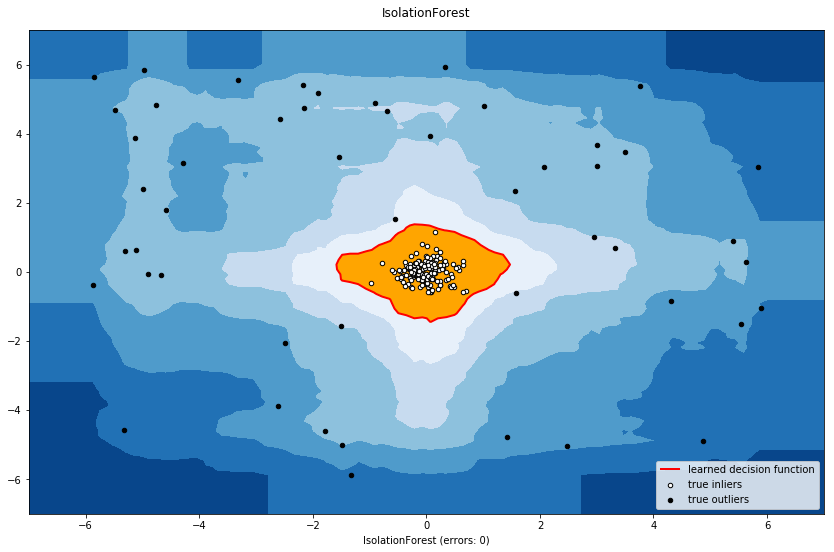

In [96]:
plot_result(iso_forest, "IsolationForest")

## 4. Local Outlier Factor

In [99]:
from sklearn.neighbors import LocalOutlierFactor
lof_clf = LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction)

LocalOutlierFactor(algorithm='auto', contamination=0.25, leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=35,
          p=2)

In [103]:
y_pred = lof_clf.fit_predict(X)
scores_pred = lof_clf.negative_outlier_factor_

In [104]:
threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)
n_errors = (y_pred != ground_truth).sum()

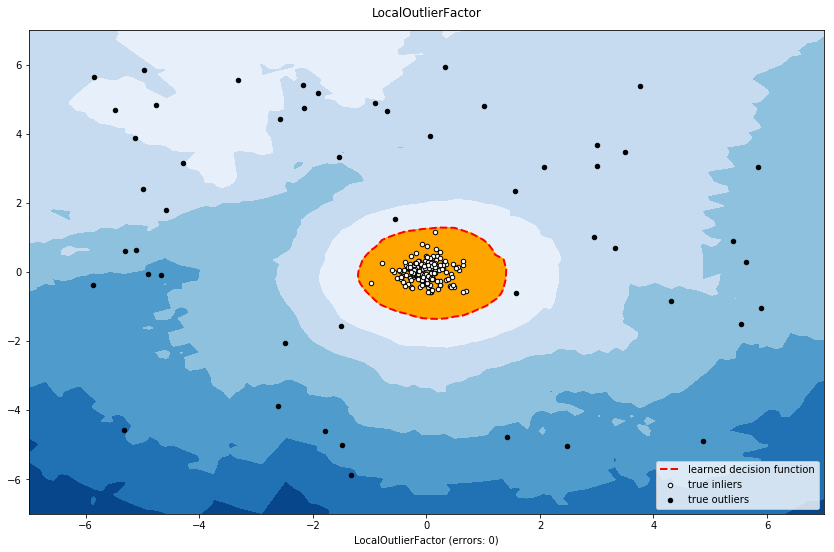

In [105]:
plot_result(lof_clf, "LocalOutlierFactor")